In [ ]:
from deepforest import main
import matplotlib.pyplot as plt
import cv2
import numpy as np
import pandas as pd

: 

Reading config file: /home/danny/anaconda3/lib/python3.9/site-packages/deepforest/data/deepforest_config.yml
Model from DeepForest release https://github.com/weecology/DeepForest/releases/tag/1.0.0 was already downloaded. Loading model from file.
Loading pre-built model: https://github.com/weecology/DeepForest/releases/tag/1.0.0


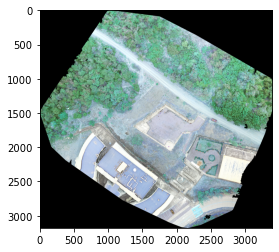

In [ ]:
m = main.deepforest()
m.use_release()
#imgpath = "Mosaicos/bosqueed.tif"
imgpath = "Mosaicos/bosq1.tif"
#imgpath = "Mosaicos/openaerealmap.tif"
#imgpath = "Mosaicos/bosque1.jpg"
imagen = cv2.imread(imgpath)
image_copy = np.copy(imagen)
plt.imshow(imagen)

In [ ]:
box = m.predict_image(path=imgpath, return_plot=False)
box.head()
#box.info

,xmin,ymin,xmax,ymax,label,score
0,47.0,1358.0,406.0,1769.0,Tree,0.142108
1,548.0,1158.0,769.0,1378.0,Tree,0.137820
2,2589.0,961.0,3268.0,1599.0,Tree,0.122976
3,1797.0,34.0,2288.0,482.0,Tree,0.120055
4,822.0,1068.0,1029.0,1275.0,Tree,0.119043


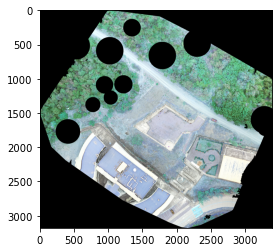

In [ ]:
mask = 255*np.ones(imagen.shape,np.uint8)
def fun(row):
    x = int(row['xmin'])
    y = int(row['ymin'])
    X1 = int(row['xmax'])
    Y1 = int(row['ymax'])
    centro = (x+(X1-x),y+(Y1-y))
    radio = int(min((Y1-y)/2,(X1-x)/2,200))
    #cv2.circle(mask,centro,radio,(0,0,0),-1)
    cv2.circle(image_copy,centro,radio,(0,0,0),-1)
    #image_copy[y:Y1,x:X1] = 0
    mask[y:Y1,x:X1] = 0
box.apply(lambda r : fun(r), axis = 1)
plt.imshow(image_copy)

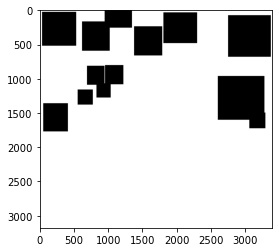

In [ ]:
plt.imshow(mask)

Erosión imagen clasificada

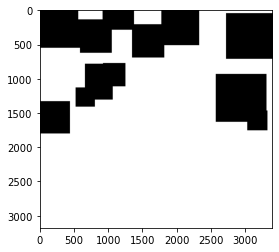

In [ ]:
kernel = np.ones((7, 7), 'uint8')
erosion = cv2.erode(mask, kernel, iterations=10)
erosion = cv2.morphologyEx(erosion, cv2.MORPH_OPEN, kernel, iterations=10)
#erosion = cv2.dilate(mask, kernel,iterations=50)
plt.imshow(erosion)

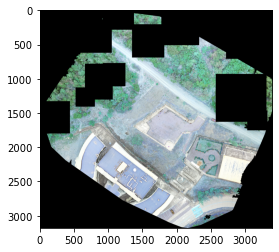

In [ ]:
fg = cv2.bitwise_and(imagen, erosion)
plt.imshow(fg)

In [ ]:
cv2.imwrite('forest.tif',fg)

True

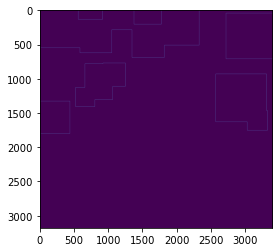

In [ ]:
edged = cv2.Canny(erosion, 0, 0)
_, threshold = cv2.threshold(edged, 100, 255, cv2.THRESH_BINARY) 
contours, _= cv2.findContours(threshold, cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE) 
plt.imshow(edged)

In [ ]:
import rasterio
dataset = rasterio.open(imgpath)
print(dataset.crs)
print(dataset.bounds)
print(dataset.transform)
print(dataset.indexes)

EPSG:32717
BoundingBox(left=615357.7497404777, bottom=9762996.70609582, right=615527.3583145756, top=9763155.536489662)
| 0.05, 0.00, 615357.75|
| 0.00,-0.05, 9763155.54|
| 0.00, 0.00, 1.00|
(1, 2, 3, 4)


In [ ]:
x, y = dataset.xy(500,400)
print(x,y)
x, y = dataset.transform * (500, 500)
print(x,y)
row, column = dataset.index(x, y)
print(row,column)

615377.7698506829 9763130.514578389
615382.7436358649 9763130.539575303
500 500


In [ ]:
print(contours)

(array([[[   0, 1327]],

       [[ 434, 1327]],

       [[ 435, 1328]],

       [[ 435, 1797]],

       [[ 434, 1798]],

       [[   0, 1798]],

       [[ 435, 1798]],

       [[ 435, 1328]],

       [[ 434, 1327]]], dtype=int32), array([[[2560,  930]],

       [[2558,  932]],

       [[2558, 1627]],

       [[2559, 1628]],

       [[3016, 1628]],

       [[3017, 1629]],

       [[3017, 1751]],

       [[3018, 1752]],

       [[3311, 1752]],

       [[3311, 1464]],

       [[3310, 1463]],

       [[3298, 1463]],

       [[3297, 1462]],

       [[3297,  931]],

       [[3296,  930]]], dtype=int32), array([[[ 918,  771]],

       [[ 916,  773]],

       [[ 916,  780]],

       [[ 915,  781]],

       [[ 655,  781]],

       [[ 653,  783]],

       [[ 653, 1126]],

       [[ 652, 1127]],

       [[ 519, 1127]],

       [[ 517, 1129]],

       [[ 517, 1406]],

       [[ 518, 1407]],

       [[ 798, 1407]],

       [[ 798, 1306]],

       [[ 800, 1304]],

       [[1058, 1304]],

       [[10

In [ ]:
import csv
data = []
data.append ({"x": "x", "y": "y","name":"name"})
data.append ({"x": dataset.bounds.left, "y": dataset.bounds.top,"name":"Borde"})
data.append ({"x": dataset.bounds.left, "y": dataset.bounds.bottom,"name":"Borde"})
data.append ({"x": dataset.bounds.right, "y": dataset.bounds.bottom,"name":"Borde"})
data.append ({"x": dataset.bounds.right, "y": dataset.bounds.top,"name":"Borde"})
poligono = []

#poligono.append([[[dataset.bounds.left,dataset.bounds.top,0.0],[dataset.bounds.left,dataset.bounds.bottom,0.0],
#[dataset.bounds.right,dataset.bounds.bottom,0.0],[dataset.bounds.right,dataset.bounds.top,0.0]]])

for cnt in contours : 

    approx = cv2.approxPolyDP(cnt, 0.009 * cv2.arcLength(cnt, True), True) 
    n = approx.ravel()  
    i = 0
    poligono1=[]
    for j in n : 
        if(i % 2 == 0): 
            x = n[i] 
            y = n[i + 1] 
            x1,y1 = dataset.xy(y, x)
            poligono1.append([x1,y1,0.0])
            data.append ({"x": x1, "y": y1,"name":"Borde"})
        i = i + 1
    poligono.append([poligono1])
with open ("output.csv", "w", newline = "") as f:
    writer = csv.DictWriter (f, fieldnames = ["x", "y","name"])
    writer.writerows (data)

In [ ]:
print(poligono)

[[[[615357.7747343731, 9763089.169682037, 0.0], [615379.51942336, 9763089.11968821, 0.0], [615379.51942336, 9763065.672582539, 0.0], [615357.7747343731, 9763065.62258871, 0.0], [615379.51942336, 9763065.62258871, 0.0], [615379.51942336, 9763089.11968821, 0.0]]], [[[615485.7434787559, 9763109.017232038, 0.0], [615485.6435031743, 9763074.17153342, 0.0], [615508.5379113491, 9763074.121539593, 0.0], [615508.6378869306, 9763067.922304831, 0.0], [615523.2843096276, 9763067.922304831, 0.0], [615522.5844805567, 9763108.96723821, 0.0]]], [[[615419.9095583059, 9763116.916256977, 0.0], [615390.5167373304, 9763116.466312518, 0.0], [615390.4167617488, 9763099.21844161, 0.0], [615383.6184222035, 9763099.068460124, 0.0], [615383.6184222035, 9763085.220169568, 0.0], [615397.6649914111, 9763085.17017574, 0.0], [615397.7649669927, 9763090.319540098, 0.0], [615410.6618170126, 9763090.319540098, 0.0], [615410.6618170126, 9763099.868361384, 0.0], [615419.9095583059, 9763099.968349041, 0.0]]], [[[615493.141

In [ ]:
polyDf = pd.read_csv('output.csv')
polyDf.head()

,x,y,name
0,615357.749740,9.763156e+06,Borde
1,615357.749740,9.762997e+06,Borde
2,615527.358315,9.762997e+06,Borde
3,615527.358315,9.763156e+06,Borde
4,615357.774734,9.763089e+06,Borde


In [ ]:
import fiona
schema = {
    'geometry':'Polygon',
    'properties':[('Name','str')]
}
#open a fiona object
polyShp = fiona.open('Poligonos/polygon.shp', mode='w', driver='ESRI Shapefile',
          schema = schema, crs = dataset.crs)

xyList = []
rowName = ''
for index, row in polyDf.iterrows():
    xyList.append((row.x,row.y))
    rowName = row.name

#save record and close shapefile
rowDict = {
'geometry' : {'type':'Polygon',
                 'coordinates': [xyList]}, #Here the xyList is in brackets
'properties': {'Name' : rowName},
}
polyShp.write(rowDict)
#close fiona object
polyShp.close()

In [ ]:
import fiona
from pprint import pprint
fn = 'Poligonos/test_mp.shp'
opts = {
    'driver': 'ESRI Shapefile',
    'schema': {'geometry': '3D MultiPolygon', 'properties': {}},
    'crs' : dataset.crs
}
with fiona.open(fn, mode='w', **opts) as c:
    c.write({'geometry': {'type': 'MultiPolygon', 'coordinates': poligono}, 'properties': {}})

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


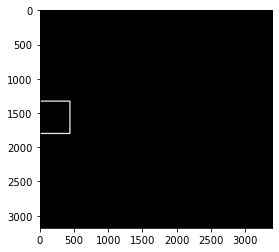

In [ ]:
cnts = cv2.findContours(threshold, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]
img_contours = np.zeros(imagen.shape)
# draw the contours on the empty image
cv2.drawContours(img_contours, contours, -0, (255,255,255), 15)

plt.imshow(img_contours)


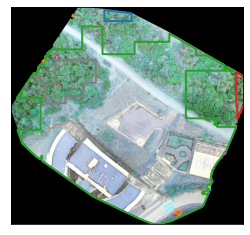

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from skimage import measure

# Find contours at a constant value of 0.8
contours = measure.find_contours(fg[:,:,1], 0.8)


# Display the image and plot all contours found
fig, ax = plt.subplots()
ax.imshow(imagen, cmap=plt.cm.gray)

for contour in contours:
    ax.plot(contour[:, 1], contour[:, 0], linewidth=2)

ax.axis('image')
ax.set_xticks([])
ax.set_yticks([])
plt.show()

In [ ]:
print(len(contours))

56


In [ ]:
poligono = []

for cnt in contours : 
    poligono1 = []
    for ind in cnt:
        print(ind)
        x1,y1 = dataset.xy(ind[0], ind[1])
        poligono1.append([x1,y1,0.0])
    poligono.append([poligono1])

'''    approx = cv2.approxPolyDP(cnt, 0.009 * cv2.arcLength(cnt, True), True) 
    n = approx.ravel()  
    i = 0
    poligono1=[]
    for j in n : 
        if(i % 2 == 0): 
            x = n[i] 
            y = n[i + 1] 
            x1,y1 = dataset.xy(y, x)
            poligono1.append([x1,y1,0.0])
            data.append ({"x": x1, "y": y1,"name":"Borde"})
        i = i + 1
    poligono.append([poligono1])
with open ("output.csv", "w", newline = "") as f:
    writer = csv.DictWriter (f, fieldnames = ["x", "y","name"])
    writer.writerows (data)'''

[ 206.99636364 1766.        ]
[ 206.99624413 1765.        ]
[ 206.99627907 1764.        ]
[ 206.99607843 1763.        ]
[ 206.99593909 1762.        ]
[ 206.99589744 1761.        ]
[ 206.9959799 1760.       ]
[ 206.99550562 1759.        ]
[ 206.99562842 1758.        ]
[ 206.99518072 1757.        ]
[ 206.99581152 1756.        ]
[ 206.9962963 1755.       ]
[ 206.99644444 1754.        ]
[ 206.99634703 1753.        ]
[ 206.99638009 1752.        ]
[ 206.9962963 1751.       ]
[ 206.99613527 1750.        ]
[ 206.99620853 1749.        ]
[ 206.99634703 1748.        ]
[ 206.99553073 1747.        ]
[ 206.99379845 1746.        ]
[ 206.9960396 1745.       ]
[ 206.99565217 1744.        ]
[ 206.99587629 1743.        ]
[ 206.9956044 1742.       ]
[ 206.9960199 1741.       ]
[ 206.99617225 1740.        ]
[ 206.99633028 1739.        ]
[ 206.99622642 1738.        ]
[ 206.99585492 1737.        ]
[ 206.9954023 1736.       ]
[ 206.99589744 1735.        ]
[ 206.9960396 1734.       ]
[ 206.99518072 1733.      

'    approx = cv2.approxPolyDP(cnt, 0.009 * cv2.arcLength(cnt, True), True) \n    n = approx.ravel()  \n    i = 0\n    poligono1=[]\n    for j in n : \n        if(i % 2 == 0): \n            x = n[i] \n            y = n[i + 1] \n            x1,y1 = dataset.xy(y, x)\n            poligono1.append([x1,y1,0.0])\n            data.append ({"x": x1, "y": y1,"name":"Borde"})\n        i = i + 1\n    poligono.append([poligono1])\nwith open ("output.csv", "w", newline = "") as f:\n    writer = csv.DictWriter (f, fieldnames = ["x", "y","name"])\n    writer.writerows (data)'

In [ ]:
import fiona
from pprint import pprint
fn = 'Poligonos/new.shp'
opts = {
    'driver': 'ESRI Shapefile',
    'schema': {'geometry': '3D MultiPolygon', 'properties': {}},
    'crs' : dataset.crs
}
with fiona.open(fn, mode='w', **opts) as c:
    c.write({'geometry': {'type': 'MultiPolygon', 'coordinates': poligono}, 'properties': {}})